<b><h1>SQuAD2.0</h1></b>


> <b>The Stanford Question Answering Dataset</b>, or SQuAD for short, is a popular dataset for training and evaluating question answering systems. SQuAD contains a large collection of questions and their corresponding answer spans, along with the context paragraph from which the answers can be found. SQuAD has been widely used in the natural language processing (NLP) community as a benchmark for evaluating the performance of question answering systems.
SQuAD 2.0 is the latest version of the SQuAD dataset, released in 2018. Unlike the original SQuAD, which only contains questions that have a definite answer in the context, <b>SQuAD 2.0</b> includes additional questions that either have an unanswerable question or require reasoning beyond the given context. This makes SQuAD 2.0 a more <b>challenging</b> dataset for question answering systems, as they must not only extract the correct answer but also determine when a question is <b>unanswerable</b> or requires additional knowledge beyond the given context.<br>

In this notebook, we will explore the SQuAD 2.0 dataset and develop a question answering model using deep learning techniques. We will begin by loading the dataset and preprocessing the data, followed by <b>training</b>, <b>evaluating</b> and <b>comparing</b> our models.



## 👨‍👨‍👧‍👦 Our team group
- ```Balestrieri Niccolò - 10936955```
- ```Bertogalli Andrea - 10702303```
- ```Musumeci Margherita - 10600069```
- ```Tombini Nicolò - 10912627```

## 🔎 Dataset Load


In this section of the code, the ```JSON``` dataset is converted into a Pandas DataFrame to enhance performance during data processing.
This conversion to a ```Pandas DataFrame``` allows for more efficient data manipulation and analysis using the rich functionality provided by ```Pandas```. It organizes the data in a tabular format, making it easier to perform various operations on the dataset.


|                         | SQuAD1.1 | SQuAD2.0 |
|:-----------------------:|:--------:|:--------:|
|        **Train**        |          |          |
|      Total examples     |   87599  |  130319  |
|    Negative examples    |     0    |   43498  |
|      Total articles     |    442   |    442   |
| Articles with negatives |     0    |    285   |
|      **Validation**     |          |          |
|      Total examples     |   10570  |   11873  |
|    Negative examples    |     0    |   5945   |
|      Total articles     |    48    |    35    |
| Articles with negatives |     0    |    35    |
|         **Test**        |          |          |
|      Total examples     |   9533   |   8862   |
|    Negative examples    |     0    |   4332   |
|      Total articles     |    46    |    28    |
| Articles with negatives |     0    |    28    |

*Test set is unknown: to preserve the integrity of test results, the authors didn't release the test set*



* Questions are posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.
* A negative example refers to an unswerable question.
* A positive example refers to an answerable question belonging to one of these categories: *Date, Numeric, Person, Location, Other Entity, Common Noun Phrase, Verb Phrase, Clause, Other*.

**SQuAD2.0 json structure**

Json_structure.svg

In [ ]:
# connect to google drive 
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLPProject/')
sys.path.append('/content/drive/MyDrive/NLPProject/lib')

# instantiate the helper class to print colored output
class bcolors:
    HEADER    = '\033[95m'
    OKBLUE    = '\033[94m'
    OKGREEN   = '\033[92m'
    WARNING   = '\033[93m'
    FAIL      = '\033[91m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

print("Completed")

Mounted at /content/drive
Completed


Due to computational limitations there's need to use Pandas to load the dataset


In [ ]:
import pandas as pd
import json
import numpy as np

def load_to_dataframe(path, val_data=False):
    data = json.load(open(path))
    record_path = ['data','paragraphs','qas','answers']
    answer_level = pd.json_normalize(data, record_path)
    qas_level = pd.json_normalize(data, record_path[:-1])
    panswer_level = pd.DataFrame()
    panswer_level['plausible_answers'] = pd.json_normalize(qas_level[qas_level['is_impossible'] == True]['plausible_answers'])
    panswer_level = pd.json_normalize(panswer_level['plausible_answers'])
    context_level = pd.json_normalize(data, record_path[:-2])
    title_level = pd.json_normalize(data, record_path[:-3])
 
    qas_level['plausible_answers'].fillna('', inplace=True)
    tdx = np.repeat(title_level['title'].values, title_level.paragraphs.str.len())
    idx = np.repeat(context_level['context'].values, context_level.qas.str.len())
    ndx  = np.repeat(qas_level['id'].values, qas_level['answers'].str.len())
    pdx  = np.repeat(qas_level['id'].values, qas_level['plausible_answers'].str.len())
    
    # In the dev_set we have some unanswerable questions that have no plausible_answer
    if(val_data):
        a = set(qas_level[qas_level['plausible_answers'].str.len() == 0]['id'])
        b = set(qas_level[qas_level['answers'].str.len() == 0]['id'])
        pdx =  np.concatenate([pdx, np.array(list(a.intersection(b)))]) 

    qas_level['context'] = idx
    answer_level['q_idx'] = ndx
    panswer_level['q_idx'] = pdx
    context_level['title'] = tdx

    answers = pd.concat([answer_level, panswer_level], ignore_index=True, axis=0)

    # After the parsing we have the dataset in a tabular format
    df = pd.merge(qas_level, answers, left_on='id', right_on='q_idx')
    df = pd.merge(df, context_level, on='context')
    df['c_id'] = df['context'].factorize()[0]
    df.drop(['id'], inplace=True, axis=1)
    df.drop(['answers'], inplace=True, axis=1)
    df.drop(['plausible_answers'], inplace=True, axis=1)
    df.drop(['qas'], inplace=True, axis=1)
    df = df.rename(columns={"text": "answer"})
    df['answer'].fillna('', inplace=True)

    # Drop rows that have same contexts, questions and answers
    df.drop_duplicates(subset=["question", "answer", "context", "q_idx"], inplace = True)

    return df

train_df = load_to_dataframe('./Dataset/train_set.json', val_data=False)
dev_df = load_to_dataframe('./Dataset/dev_set.json', val_data=True)
print("Dataset correctly imported!")

Dataset correctly imported!


## 📊 Preliminary analysis

In this section of the ```Colab notebook```, preliminary analysis is conducted on the ```SQuADV2``` dataset, and visualizations in the form of histograms and word clouds are displayed.

This section provides valuable insights into the dataset, including the frequency of different types of questions and answers, as well as the most common words used. The visualizations help in understanding the distribution and importance of words in the dataset.

Data:
- ```Training set```
- ```Validation set```

Analysis:

- ```Number of contexts```
- ```Number of questions (also divided among answerable and not answerable)```
- ```Number of answers```
- ```Number of non-answerable questions```
- ```Average contexts length```
- ```Average questions length```
- ```Average answer length```
- ```Total vocabulary size (contexts and questions)```
- ```Word frequency (questions and answers with and without stopwords)```

In [ ]:
train_df.head()

,question,is_impossible,context,answer,answer_start,q_idx,title,c_id
0,When did Beyonce start becoming popular?,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269,56be85543aeaaa14008c9063,Beyoncé,0
1,What areas did Beyonce compete in when she was...,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207,56be85543aeaaa14008c9065,Beyoncé,0
2,When did Beyonce leave Destiny's Child and bec...,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526,56be85543aeaaa14008c9066,Beyoncé,0
3,In what city and state did Beyonce grow up?,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166,56bf6b0f3aeaaa14008c9601,Beyoncé,0
4,In which decade did Beyonce become famous?,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276,56bf6b0f3aeaaa14008c9602,Beyoncé,0


In [ ]:
dev_df.head()

,question,is_impossible,context,answer,answer_start,q_idx,title,c_id
0,In what country is Normandy located?,False,The Normans (Norman: Nourmands; French: Norman...,France,159.0,56ddde6b9a695914005b9628,Normans,0
4,When were the Normans in Normandy?,False,The Normans (Norman: Nourmands; French: Norman...,10th and 11th centuries,94.0,56ddde6b9a695914005b9629,Normans,0
5,When were the Normans in Normandy?,False,The Normans (Norman: Nourmands; French: Norman...,in the 10th and 11th centuries,87.0,56ddde6b9a695914005b9629,Normans,0
8,From which countries did the Norse originate?,False,The Normans (Norman: Nourmands; French: Norman...,"Denmark, Iceland and Norway",256.0,56ddde6b9a695914005b962a,Normans,0
12,Who was the Norse leader?,False,The Normans (Norman: Nourmands; French: Norman...,Rollo,308.0,56ddde6b9a695914005b962b,Normans,0


### 💾 Let's print some statistics about the datasets:

In [ ]:
# Prints some stats about the dataset
def print_stats(df):
    print("Number of texts:\t\t\t {}".format(len(df['context'].unique())))
    print("Number of questions:\t\t\t {}".format(len(df['q_idx'].unique())))
    
    quest = len(df[df['is_impossible'] == False]['q_idx'].unique())
    quest_un = len(df[df['is_impossible'] == True]['q_idx'].unique())
    print("Number of answerable questions:\t\t {}\t({}%)".format(quest, round((quest*100)/len(df['q_idx'].unique()),2)))
    print("Number of non answerable questions:\t {}\t({}%)".format(quest_un, round((quest_un*100)/len(df['q_idx'].unique())),2))
    
    print("Mean length of the texts:\t\t {}\tASCII characters".format(round(df['context'].apply(len).mean())))
    print("Mean length of the questions:\t\t {}\tASCII characters".format(round(df['question'].apply(len).mean())))
    print("Mean length of the answers:\t\t {}\tASCII characters".format(round(df['answer'].apply(len).mean())))
    print("Mean number of questions per text\t {}".format(round(train_df.groupby('context').size().mean(),2)))

    strings = df[['context', 'question']].values.flatten().tolist()
    word_set = set([w.lower() for s in strings for w in s.split() if w])
    print("Contexts & Questions vocabulary size:\t {}\twords\n".format(len(word_set)))
    

print(bcolors.HEADER + "Analysing {}...".format("train_set.json") + bcolors.ENDC)
print_stats(train_df)
print(bcolors.HEADER + "Analysing {}...".format("dev_set.json") + bcolors.ENDC)
print_stats(dev_df)

print("\nCompleted!")

Analysing train_set.json...
Number of texts:			 19029
Number of questions:			 130319
Number of answerable questions:		 86821	(66.62%)
Number of non answerable questions:	 43498	(33%)
Mean length of the texts:		 755	ASCII characters
Mean length of the questions:		 59	ASCII characters
Mean length of the answers:		 20	ASCII characters
Mean number of questions per text	 6.85
Contexts & Questions vocabulary size:	 199689	words

Analysing dev_set.json...
Number of texts:			 1204
Number of questions:			 11873
Number of answerable questions:		 5928	(49.93%)
Number of non answerable questions:	 5945	(50%)
Mean length of the texts:		 814	ASCII characters
Mean length of the questions:		 60	ASCII characters
Mean length of the answers:		 23	ASCII characters
Mean number of questions per text	 6.85
Contexts & Questions vocabulary size:	 31622	words


Completed!


### 📈 Let's see some charts:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Analysing train_set.json...


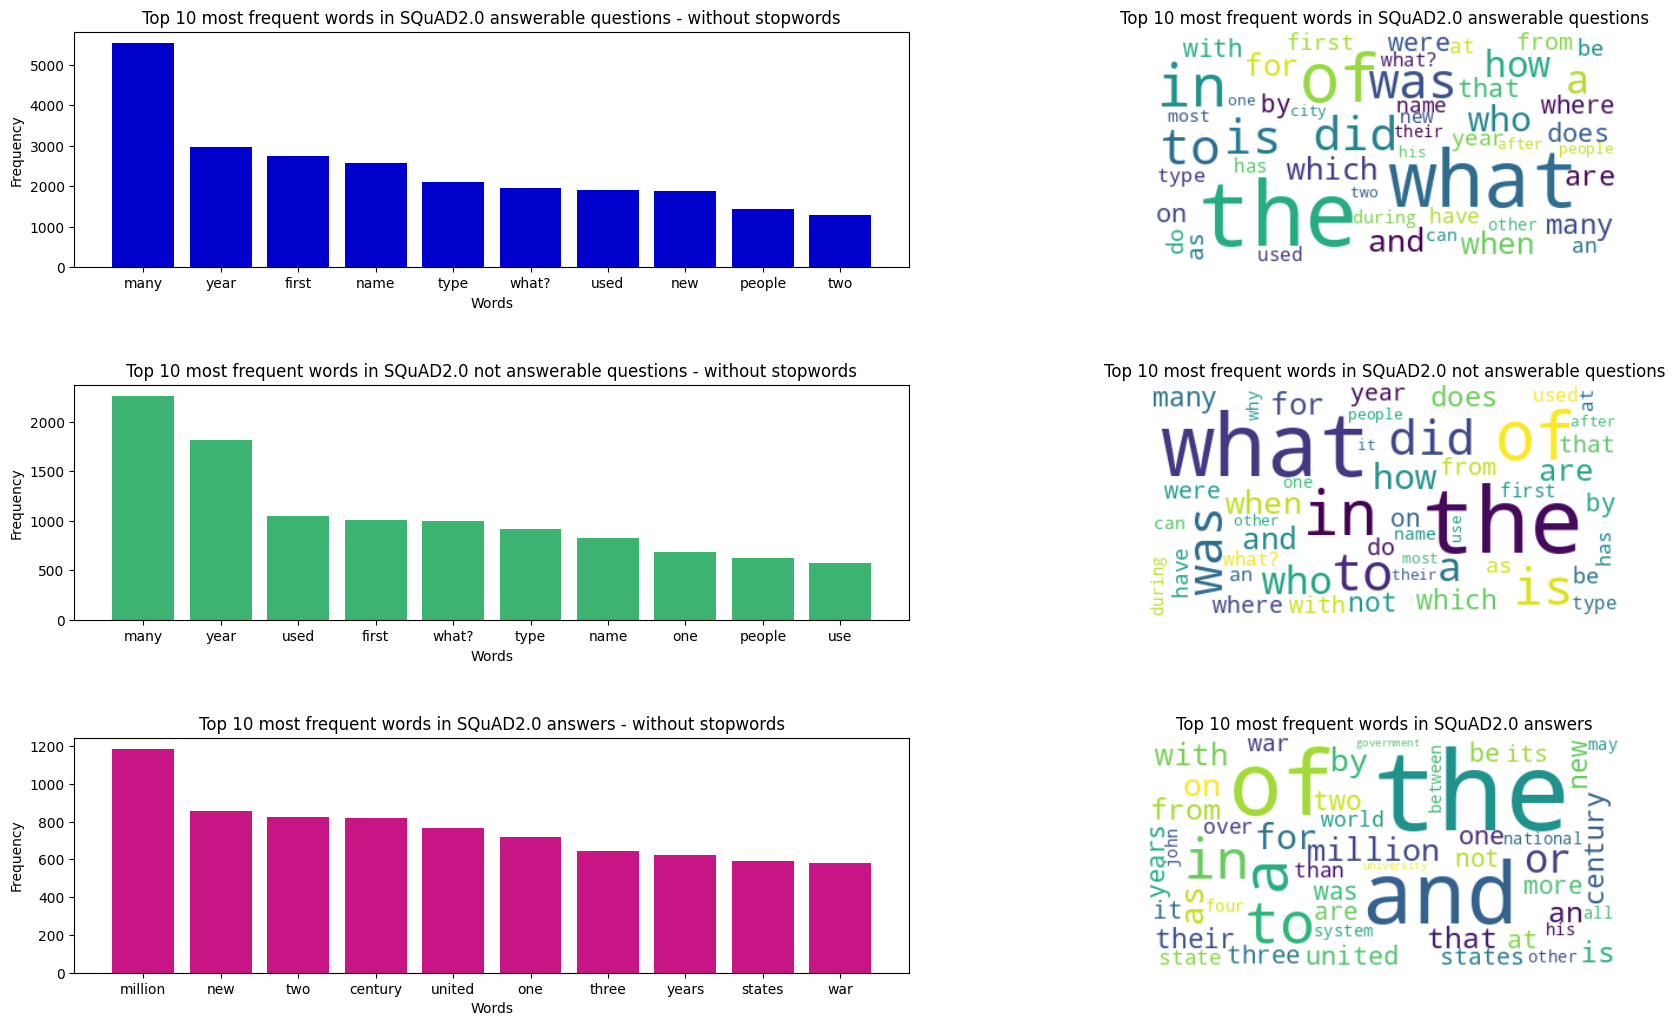



Analysing dev_set.json...


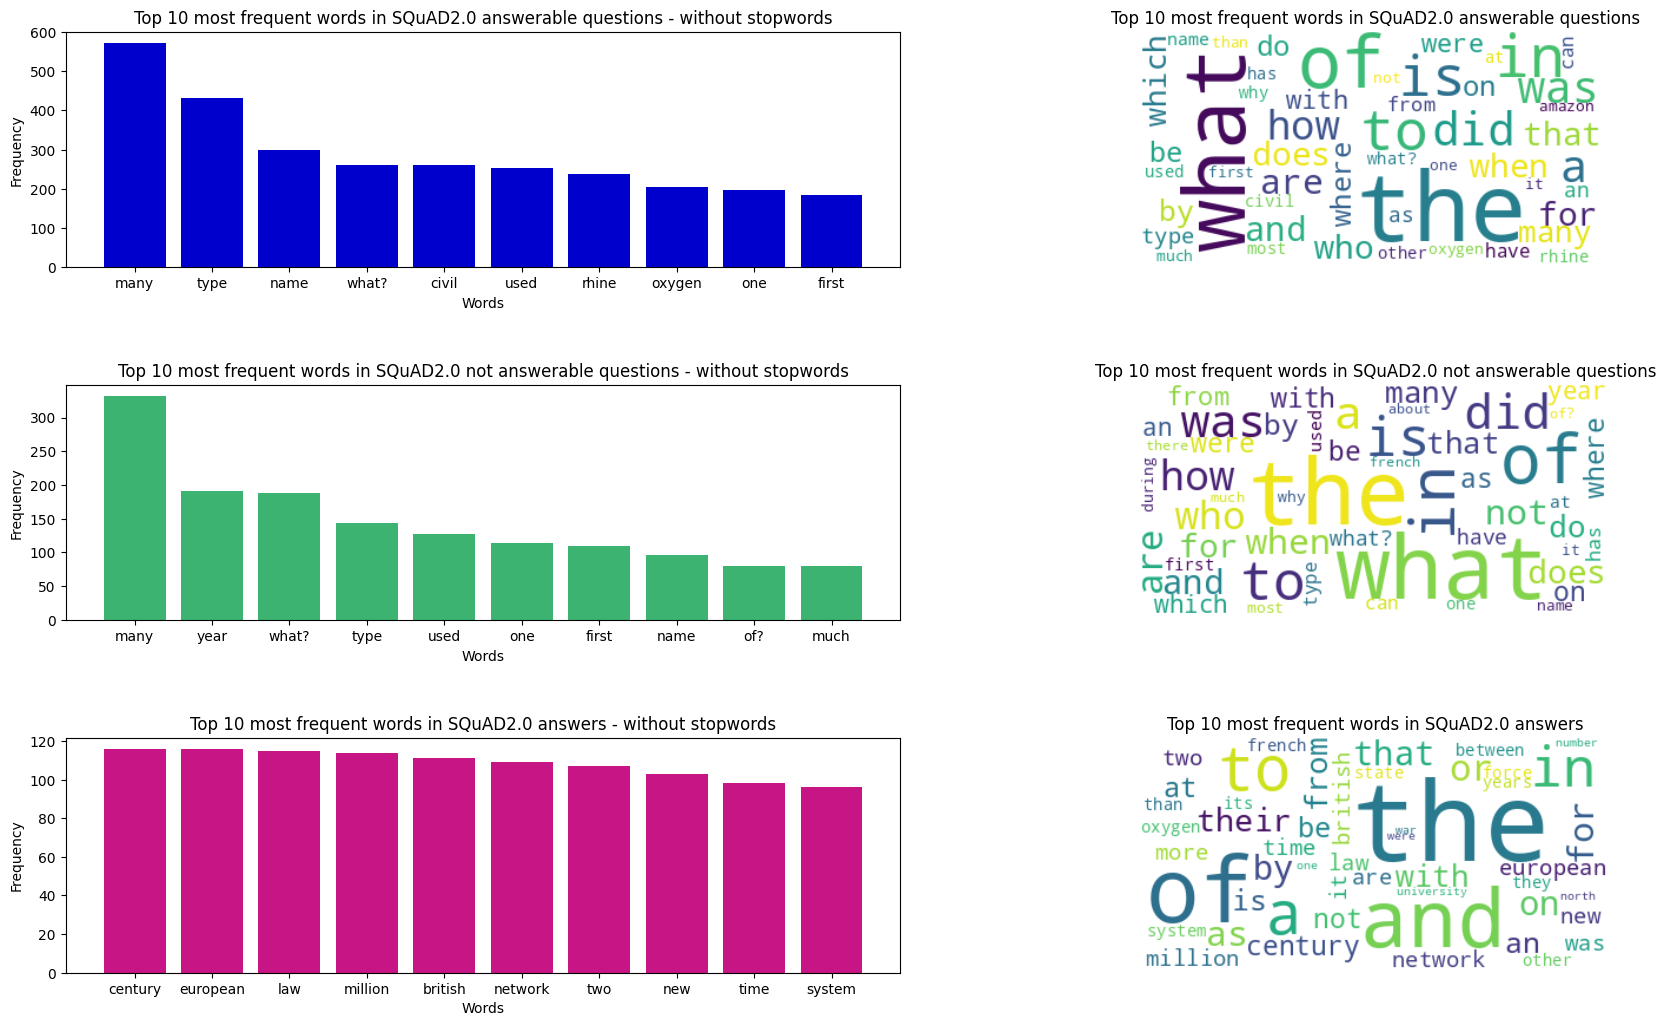




Completed!


In [ ]:
import nltk
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('stopwords')

# Plots some stats about the dataset
def plot_stats(df, english_stopwords):
    strings = df[df['is_impossible'] == False]['question'].values.flatten().tolist()
    tokens_quest = [w.lower() for s in strings for w in s.split() if w]
    word_freq_q_answ = Counter(tokens_quest)

    strings = df[df['is_impossible'] == True]['question'].values.flatten().tolist()
    tokens_un_quest = [w.lower() for s in strings for w in s.split() if w]
    word_freq_q_not_answ = Counter(tokens_un_quest)

    strings = df['answer'].values.flatten().tolist()
    tokens_answ = [w.lower() for s in strings for w in s.split() if w]
    word_freq_a = Counter(tokens_answ)

    word_freq_q_answ_nostopwords = Counter([w for w in tokens_quest if w not in english_stopwords])
    word_freq_q_not_answ_nostopwords = Counter([w for w in tokens_un_quest if w not in english_stopwords])
    word_freq_a_nostopwords = Counter([w for w in tokens_answ if w not in english_stopwords])

    # Extract the top 10 most frequent words from answerable, not answerable questions and answers
    top_words_q_answ = word_freq_q_answ_nostopwords.most_common(10)
    top_words_q_not_answ = word_freq_q_not_answ_nostopwords.most_common(10)
    top_words_a = word_freq_a_nostopwords.most_common(10)

    # Plot in a WordCloud the most common words in the answers
    dict_cloud_answ = {}
    for item in word_freq_a.most_common(50):
      dict_cloud_answ[item[0]] = item[1]

    wordcloud_answ = WordCloud(background_color='white').generate_from_frequencies(dict_cloud_answ)

    # Plot in a WordCloud the most common words in the answerable questions
    dict_cloud_q_answ = {}
    for item in word_freq_q_answ.most_common(50):
      dict_cloud_q_answ[item[0]] = item[1]

    wordcloud_q_answ = WordCloud(background_color='white').generate_from_frequencies(dict_cloud_q_answ)

    # Plot in a WordCloud the most common words in the not answerable questions
    dict_cloud_q_not_answ = {}
    for item in word_freq_q_not_answ.most_common(50):
      dict_cloud_q_not_answ[item[0]] = item[1]

    wordcloud_q_not_answ = WordCloud(background_color='white').generate_from_frequencies(dict_cloud_q_not_answ)
    
    # Plot in a subplot 3x2 all the details about word frequency
    fig, axs = plt.subplots(3, 2, figsize=(18, 10))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    axs[0, 0].bar([w[0] for w in top_words_q_answ], [w[1] for w in top_words_q_answ], color = 'mediumblue')
    axs[0, 0].title.set_text('Top 10 most frequent words in SQuAD2.0 answerable questions - without stopwords')
    axs[0, 0].set_xlabel('Words')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 1].imshow(wordcloud_q_answ, interpolation='bilinear')
    axs[0, 1].title.set_text('Top 10 most frequent words in SQuAD2.0 answerable questions')
    axs[0, 1].axis('off')
    axs[1, 0].title.set_text('Top 10 most frequent words in SQuAD2.0 not answerable questions - without stopwords')
    axs[1, 0].set_xlabel('Words')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].bar([w[0] for w in top_words_q_not_answ], [w[1] for w in top_words_q_not_answ], color = 'mediumseagreen')
    axs[1, 1].imshow(wordcloud_q_not_answ, interpolation='bilinear')
    axs[1, 1].title.set_text('Top 10 most frequent words in SQuAD2.0 not answerable questions')
    axs[1, 1].axis('off')
    axs[2, 0].bar([w[0] for w in top_words_a], [w[1] for w in top_words_a], color = 'mediumvioletred')
    axs[2, 0].title.set_text('Top 10 most frequent words in SQuAD2.0 answers - without stopwords')
    axs[2, 0].set_xlabel('Words')
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 1].imshow(wordcloud_answ, interpolation='bilinear')
    axs[2, 1].title.set_text('Top 10 most frequent words in SQuAD2.0 answers')
    axs[2, 1].axis('off')
    plt.show()
    print('\n')

english_stopwords = stopwords.words('english')    
print(bcolors.HEADER + "Analysing {}...".format("train_set.json") + bcolors.ENDC)
plot_stats(train_df, english_stopwords)
print(bcolors.HEADER + "Analysing {}...".format("dev_set.json") + bcolors.ENDC)
plot_stats(dev_df, english_stopwords)

print("\nCompleted!")

## 📊 Deeper analysis:

Initially, ```Word2Vec``` was applied to the contextual words in order to generate word embeddings. The ```Word2Vec``` algorithm is commonly used to create dense vector representations of words, capturing their semantic meaning. Through this process, numerical representations of each word in the context were obtained.

Next, the word embeddings were visualized using ```t-SNE``` (t-Distributed Stochastic Neighbor Embedding) to plot them in a two-dimensional space. ```t-SNE``` reduces the dimensionality of the high-dimensional word vectors while preserving their pairwise relationships. This allowed for the examination of word similarity based on their proximity in the ```t-SNE``` plot.

Following that, the context data underwent ```TF-IDF vectorization``` and ```Doc2Vec``` modeling. These techniques were applied to capture the characteristics and relationships within the context. The resulting representations were then subjected to ```K-means``` clustering to observe any differences in the quality of clustering.

Finally, the contexts were indexed, and a keyword search was performed using the ```BM25``` algorithm. This indexing and keyword search approach allowed for efficient retrieval of relevant contexts based on user-defined keywords, enabling quick and targeted information retrieval.





### 📏 Word2Vec


Subsequently, the sentences were extracted as arrays of words from the contexts, and data cleaning procedures were applied to ensure optimal data quality for the ```Word2Vec``` model. These data cleaning steps aimed to enhance the effectiveness of subsequent analyses and computations.

In [ ]:
import string

# Data cleaning for Word2Vec
df_w2v = pd.DataFrame()
df_w2v['context'] = train_df['context'].unique()
df_w2v['context'] = df_w2v['context'].str.replace('\n', '')
df_w2v['context'] = df_w2v['context'].str.lower()
df_w2v['context'] = df_w2v['context'].str.split('[?!.]\s', regex=True)
df_w2v = df_w2v.explode('context')
df_w2v = df_w2v.reset_index(drop=True)
df_w2v['context'] = df_w2v['context'].str.replace('[{}]'.format(string.punctuation), '', regex = True)
df_w2v['context'] = df_w2v['context'].str.split(' ', regex=False)

print(df_w2v.head())

sentences = np.array(df_w2v['context'].to_numpy())

print("\nCompleted!")

                                             context
0  [beyoncé, giselle, knowlescarter, biːˈjɒnseɪ, ...
1  [born, and, raised, in, houston, texas, she, p...
2  [managed, by, her, father, mathew, knowles, th...
3  [their, hiatus, saw, the, release, of, beyoncé...
4  [following, the, disbandment, of, destinys, ch...

Completed!


Then, the ```Word2Vec``` model was trained to extract word embeddings, focusing on examining the terms most closely associated with, for instance, "Beyoncé".

In [ ]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences, vector_size=30, min_count=5, window=10)
print("How big the vocabulary is " + str(len(model.wv)) + "\n")

term ='beyoncé'

print(model.wv.most_similar(term.lower()))

print("\nCompleted!")

How big the vocabulary is 23733

[('studio', 0.9151796102523804), ('album', 0.9088417887687683), ('spielberg', 0.9019789695739746), ('grammy', 0.897350013256073), ('madonna', 0.8957479000091553), ('solo', 0.8942446708679199), ('soundtrack', 0.8918235898017883), ('mtv', 0.8692930936813354), ('idol', 0.8645403981208801), ('winner', 0.8597239255905151)]

Completed!


To improve the analysis, a sort of clustering approach was implemented by employing ```TSNE``` (t-Distributed Stochastic Neighbor Embedding) to reduce the dimensionality of the word embeddings and plot them in a two-dimensional space. This technique facilitated the visualization of similar words and enabled a more comprehensive understanding of their semantic relationships.

In [ ]:
words_of_interest = ['beyoncé', 'century', 'city', 'government', 'people', 'united', 'system', 'population']

# Here we collect top 30 most similar words
embedding_clusters = []
word_clusters = []
for word in words_of_interest:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    # Contains the similar words goups
    embedding_clusters.append(embeddings) 
    word_clusters.append(words)

print("Completed!")

Completed!


In [ ]:
from sklearn.manifold import TSNE

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

# Here we project the data points from the embedding space to a lower dimensional space (2 dimension) thanks to TSNE
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

print("Completed!")

Completed!


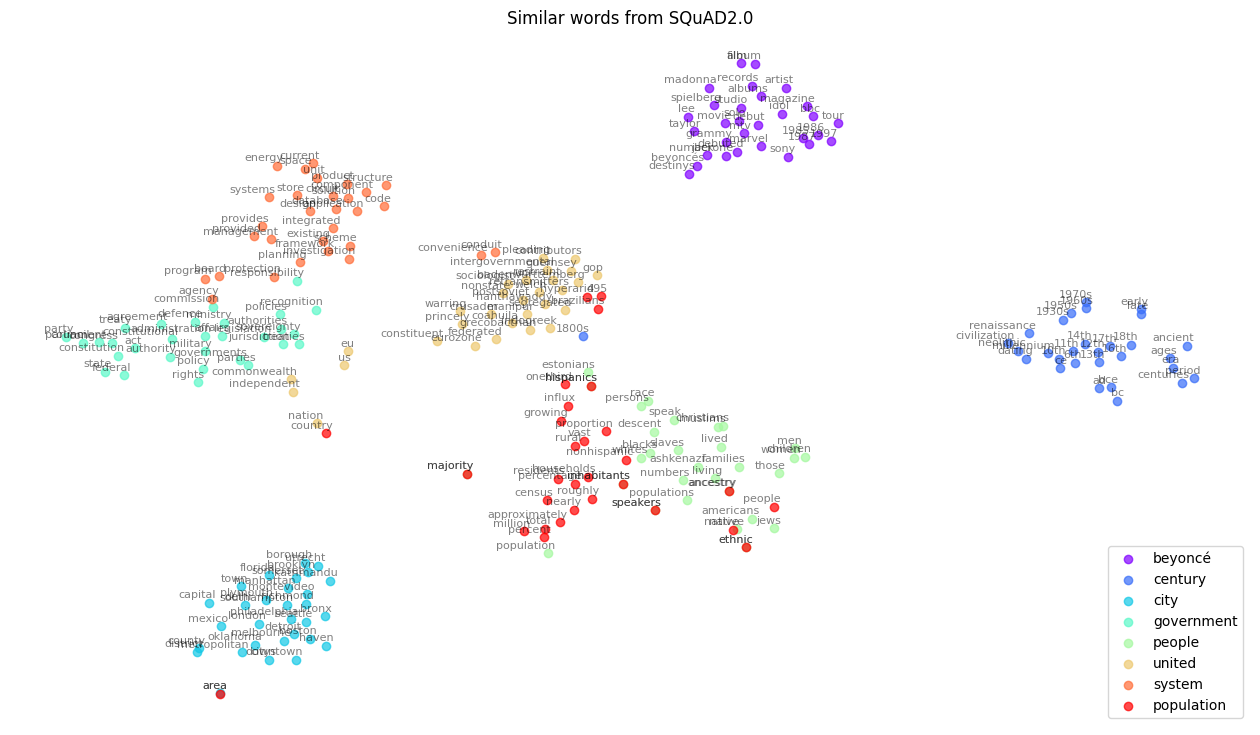


Completed!


In [ ]:
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=8)
    
    plt.legend(loc=4)
    plt.title(title)
    plt.axis('off')
    plt.show()

tsne_plot_similar_words('Similar words from SQuAD2.0', words_of_interest, embeddings_en_2d, word_clusters)

print("\nCompleted!")

### 📑 Text Clustering & Doc2Vec
And now... ```Doc2Vec``` vs ```TF-IDF Vectorizer```.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

grouped = train_df.groupby('title')['context'].apply(' '.join).reset_index()
n_clusters = 6

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
matrix = vectorizer.fit_transform(grouped["context"])

print("Completed!")

Completed!


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, init='random', max_iter=1000)
cluster_labels = kmeans.fit_predict(matrix.toarray())

print("Completed!")

Completed!


In [ ]:
tsne_matrix_tfidf = tsne_model_en_2d.fit_transform(matrix.toarray())

print("Completed!")

Completed!


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_docs = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(grouped['context'])]
doc2vec = Doc2Vec(tagged_docs, vector_size=50, window=5, min_count=1, epochs=20)

embeddings = []
for i, context in enumerate(grouped['context']):
  embeddings.append(doc2vec.infer_vector(context.split()))

kmeans = KMeans(n_clusters=n_clusters, init='random', max_iter=1000)
d2v_labels = kmeans.fit_predict(embeddings)

tsne_matrix = tsne_model_en_2d.fit_transform(np.array(embeddings))

print("Completed!")

Completed!


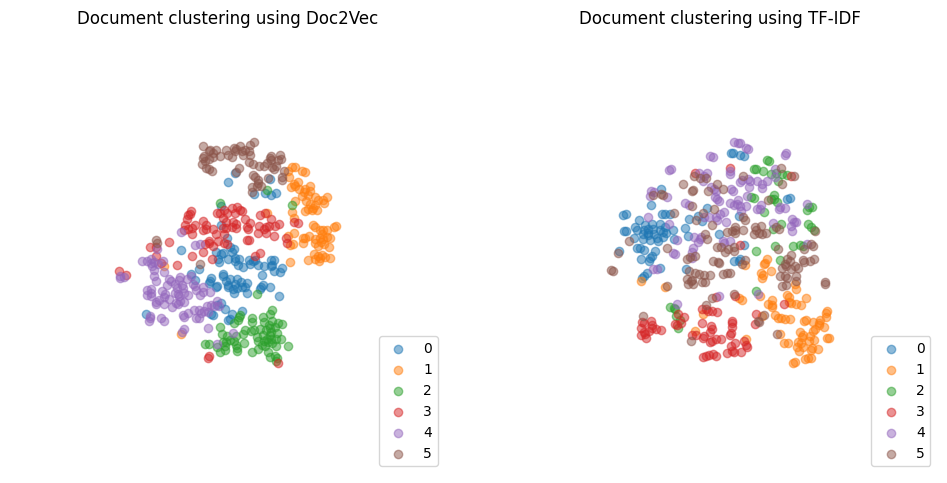

Completed!


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

for label in set(d2v_labels):
    idxs = d2v_labels == label
    axs[0].scatter(tsne_matrix[idxs, 0], tsne_matrix[idxs, 1], label=label, alpha=0.5)

axs[0].legend(loc=4)
axs[0].grid('true')
axs[0].title.set_text("Document clustering using Doc2Vec")
axs[0].axis('off')
axs[0].margins(0.5)

for label in set(cluster_labels):
    idxs = cluster_labels == label
    axs[1].scatter(tsne_matrix_tfidf[idxs, 0], tsne_matrix_tfidf[idxs, 1], label=label, alpha=0.5)

axs[1].axis('off')
axs[1].grid('true')
axs[1].legend(loc=4)
axs[1].title.set_text("Document clustering using TF-IDF")
axs[1].margins(0.5)
plt.show()

print("Completed!")

It can be seen from the graphs that the clustering done from the embeddings generated by ```doc2vec``` is better than that based on ```tf-idf```.

### 🗂️ Indexing the Contexts & Keyword Search 

In [ ]:
!pip install -q python-terrier -q

print("Completed!")

Completed!


In [ ]:
import pyterrier as pt
import warnings
warnings.filterwarnings("ignore")

if not pt.started():
  pt.init()

df_index = pd.DataFrame(train_df['context'].unique(), columns=['context'])
df_index['docno'] =  'd' + df_index.index.astype(str)

# Index the collection
indexer = pt.DFIndexer("/content/index_SQuAD2.0_contexts", overwrite=True)
index_ref = indexer.index(df_index["context"], df_index["docno"])
index = pt.IndexFactory.of(index_ref)

# Print some statistics about the indexed collection
print(bcolors.HEADER + index.getCollectionStatistics().toString() + bcolors.ENDC)

tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

print("Completed!")

Number of documents: 19029
Number of terms: 56194
Number of postings: 991498
Number of fields: 0
Number of tokens: 1284468
Field names: []
Positions:   false

Completed!


In [ ]:
query = 'Beyoncé Giselle Knowles-Carter'
result = bm25.search(query)
result[:10]

print("Completed!")

Completed!


The top three more relevant contexts for the keyword *'Beyoncé Giselle Knowles-Carter'* came from the same [Wikipedia Page](https://en.wikipedia.org/wiki/Beyonc%C3%A9) 

In [ ]:
for id in result[:3]['docid']:
  print(bcolors.HEADER + "Context document {}".format(id) + bcolors.ENDC)
  print(df_index[df_index['docno']== 'd' + str(id)]['context'].values[0] + '\n')

print("Completed!")

Context document 3
Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager. Beyoncé's name is a tribute to her mother's maiden name. Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child. Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry). Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard. She was raised in a Methodist household.

Context document 0
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Ma

In this phase of analysis, the inverse document frequency index (```IDF```) was utilized to examine the occurrence of rare terms within the contexts. This approach aimed to identify and evaluate the infrequent terms that appeared in the context data.

In [ ]:
from collections import Counter

word_counts = Counter(word for sentence in df_w2v['context'] for word in sentence)
N = len(df_w2v)
idfs = {}

for word, count in word_counts.items():
    idf = np.log(N / count)
    idfs[word] = idf if count > 0 else 0.0

idfs = dict(sorted(idfs.items(), key=lambda item: -item[1]))
print( bcolors.HEADER + "The rarest words of the contexes are:"+ bcolors.ENDC)
print(list(idfs)[:10])

print("\nCompleted!")

The rarest words of the contexes are:
['knowlescarter', 'biːˈjɒnseɪ', 'beeyonsay', 'girlgroup', 'alterego', 'recordsetting', 'mellower', 'beyincé', 'cajun', 'broussard']

Completed!


## 🏃🏻 Training models

In this section of the ```Colab notebook```, the ```T5``` and ```BERT``` models are fine-tuned using the ```SQuAD2.0``` (Stanford Question Answering Dataset) dataset. The objective is to train these models to perform question answering tasks and evaluate their performance.

The ```T5``` and ```BERT``` models are then initialized with their pre-trained weights. Fine-tuning involves updating the model parameters on the ```SQuAD2.0``` dataset to adapt them for the question answering task. This typically includes fine-tuning the model's attention mechanisms, encoding layers, and output layers.

After training, the performance of the fine-tuned models is evaluated using evaluation metrics specific to question answering tasks. Common metrics include ```Exact Match (EM)```, which measures the percentage of predicted answers that match the ground-truth exactly, and ```F1 score```, which captures the overlap between predicted and ground-truth answer spans.

The code calculates and reports the performance metrics for both the ```T5``` and ```BERT``` models on the validation set. This allows for a quantitative assessment of their question answering capabilities.


### 5️⃣ Fine-tune T5-base model from [Huggingface](https://huggingface.co/t5-base) 🤗

Initially, it was sperimented the ```T5``` model, a `Text-To-Text Transfer Transformer`, as our solution for question answering. The T5 model, specifically the 5t-base version utilized, comprised a total of `220 million` parameters.  

T5-base model is known for its impressive performance in various natural language processing tasks despite its small size. It has been widely recognized for its ability to generate high-quality text, including translation, summarization, and question-answering. The model is pre-trained on a massive amount of data from 4 different languages.

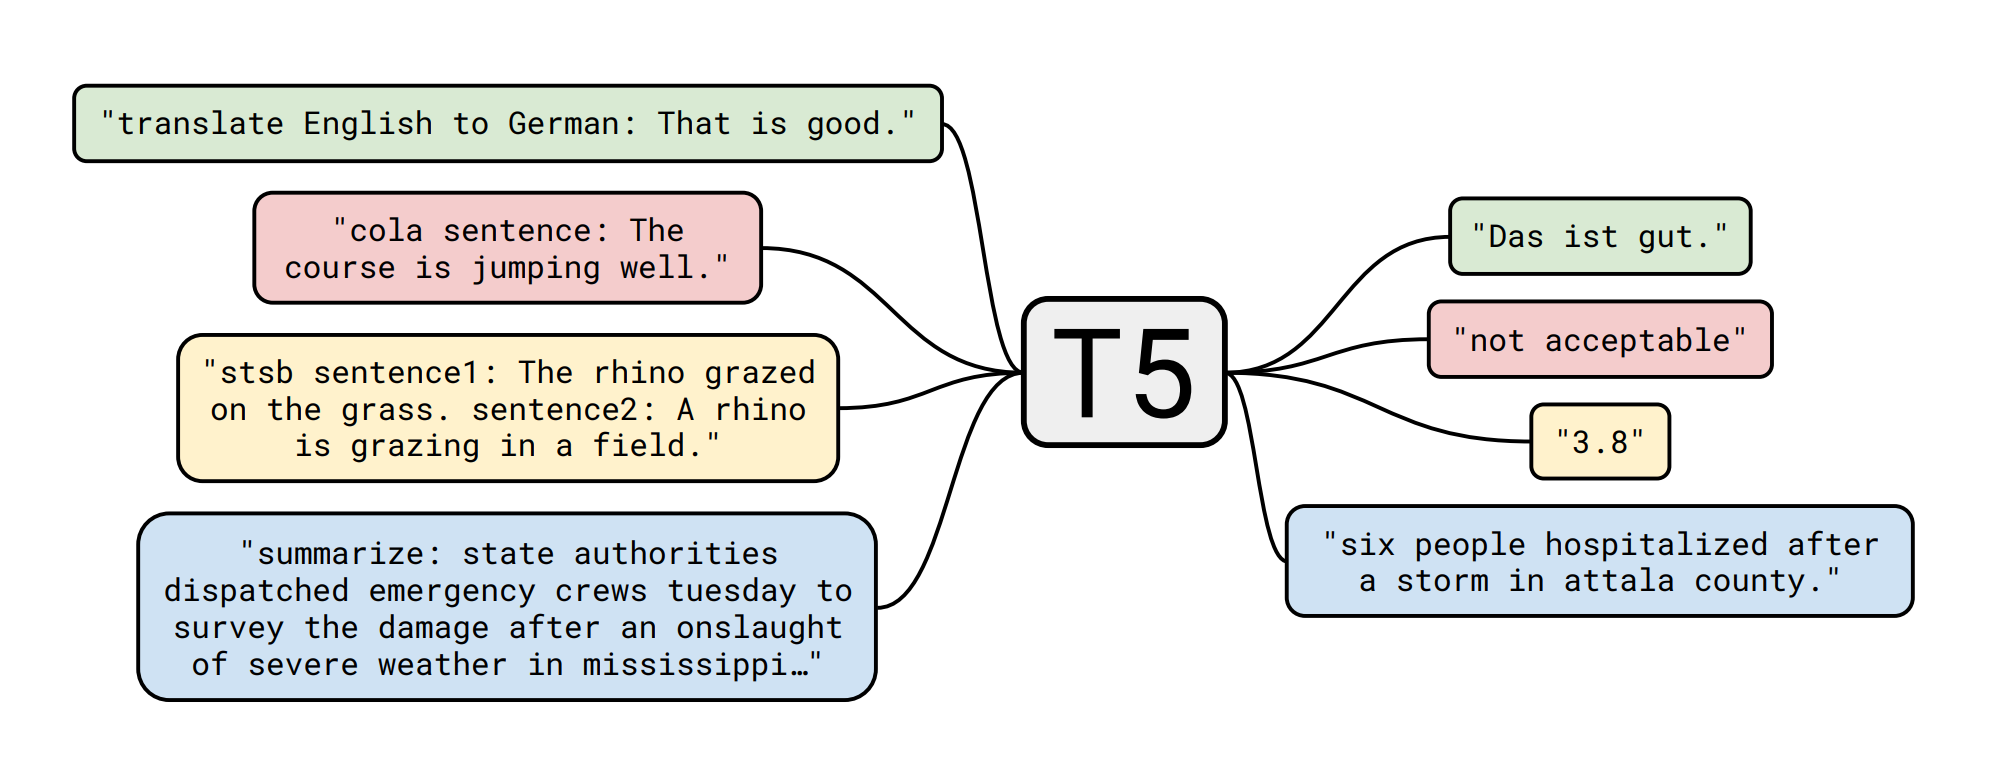

The T5-base model, as released by Google, was not specifically trained on the SQuAD 2.0 dataset.  That's why it was decided to evaluate its performance before fine-tuning was conducted.

**Results:**

**0 epoch**

> F1 mean: 0.8158634470326993

> EM score mean: 0.5602685086097869

**1 epoch**

> F1 mean: 0.8183042084177995

> EM score mean: 0.5579336511333788

**2 epochs**

> F1 mean: 0.8061164133441229

> EM score mean: 0.542562506080358

Before the beginning of the fine-tuning procedure, the model achieves an average F1 score of approximately 0.816, demonstrating already strong language understanding capabilities. The initial average exact match (EM) score is about 0.560, meaning that the model provides the exact correct answer for about 56% of the questions.

After the first epoch, there is a slight performance improvement. The average F1 score increases to approximately 0.818, indicating a slight improvement in answer accuracy. However, the average EM score decreases a bit.

By the second epoch, there is a noticeable decrease in performance which suggest that training T5-base on the SQuAD 2.0 dataset for more epochs may not lead to continued improvement in performance. 

In [ ]:
! pip install transformers==4.28.0 -q

print("Completed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.1 MB/s eta 0:00:00
Completed!


In [ ]:
! pip install datasets -q

print("Completed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
Completed!


####<h4><b>🛠️Dataset and Model preparation</b></h4>

The initial step involves importing the model and tokenizer from the Huggingface transformers library. Next, the data is loaded and processed to make it compatible with the model by tokenizing it.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import Dataset
import torch

# Define the model and the tokenizer
model_type = 't5-base'
model_fine_tuned_1_epoch = './Models/t5/t5_v1'
model_fine_tuned_2_epochs = './Models/t5_v2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    print('GPU device not found')

tokenizer = AutoTokenizer.from_pretrained(model_type, model_max_length = 1024)

# change here if you want to train t5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_fine_tuned_2_epochs, config = 'config' ).to(device)

# Convert from pandas DataFrames
train_df_answerable = train_df[train_df['is_impossible']==False]
dev_df_answerable = dev_df[dev_df['is_impossible']==False]
train_df_t5 = Dataset.from_pandas(train_df_answerable)
dev_df_t5 = Dataset.from_pandas(dev_df_answerable)

print("Completed!")

Completed!


In [ ]:
# Concatenate question and content adding specific keywords ('Question' and 'Context')
# Add 'end of a sentence' token
def add_eos_to_examples(example):
    example['input_text'] = 'question: {}  context: {} </s>'.format(example['question'], example['context'])
    example['target_text'] = '{} </s>'.format(example['answer'])
    return example

# Tokenize
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], truncation = True, pad_to_max_length=True, max_length=1024)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], truncation = True, pad_to_max_length=True, max_length=512)
    encodings = {
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask'],
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask']    
    }
    return encodings

# map add_eos_to_examples function to the dataset example wise 
train_df_t5 = train_df_t5.map(add_eos_to_examples)
# map convert_to_features batch wise
train_df_t5 = train_df_t5.map(convert_to_features, batched=True)

# map add_eos_to_examples function to the dataset example wise 
dev_df_t5 = dev_df_t5.map(add_eos_to_examples)
# map convert_to_features batch wise
dev_df_t5 = dev_df_t5.map(convert_to_features, batched=True)

# set the tensor type and the columns which the dataset should return
columns = ['input_ids', 'target_ids', 'attention_mask', 'target_attention_mask']
train_df_t5.set_format(type='torch', columns=columns)
dev_df_t5.set_format(type='torch', columns=columns)

print("Completed!")

Map:   0%|          | 0/86821 [00:00<?, ? examples/s]

Map:   0%|          | 0/86821 [00:00<?, ? examples/s]

Map:   0%|          | 0/10279 [00:00<?, ? examples/s]

Map:   0%|          | 0/10279 [00:00<?, ? examples/s]

Completed!


####<h3><b>🏋️‍♂️Let's train our model</b></h3>

<p>Please note that this will take a long time, so if you have trained the model once you can skip this cell. The saved model has been loaded in the cells before.</p>

In [ ]:
from typing import Dict, List

# Take a list of samples from a Dataset and collate them into a batch
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, batch: List[Dict]) -> Dict[str, torch.Tensor]:
        input_ids = torch.stack([example['input_ids'] for example in batch])
        lm_labels = torch.stack([example['target_ids'] for example in batch])
        lm_labels[lm_labels[:, :] == 0] = -100
        attention_mask = torch.stack([example['attention_mask'] for example in batch])
        decoder_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])

        encodings =  {
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
            'labels': lm_labels, 
            'decoder_attention_mask': decoder_attention_mask
        }
        return encodings

data_collator = DataCollator(tokenizer)

print("Completed!")

Completed!


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="/content/model_parameters",   # Output directory
    overwrite_output_dir=True,                # True if we want to overwrite the content of the output directory
    num_train_epochs=2,                       # Number of training epochs
    per_device_train_batch_size=2,            # Batch size for training
    per_device_eval_batch_size=2,             # Batch size for evaluation
    logging_strategy="steps",                 # The logging strategy to adopt during training
    logging_steps=1000,                       # Number of update steps between two logs if logging_strategy="steps".
    eval_steps=1000,                          # Number of update steps between two evaluations
    save_steps=1000,                          # Number of update steps before saving the update model 
    warmup_steps=1000,                        # Number of warmup steps for learning rate scheduler
    learning_rate= 1e-4,                      # The initial learning rate for AdamW optimizer
    fp16 = True,                              # Whether to use bf16 16-bit (mixed) precision training instead of 32-bit training
    remove_unused_columns=False
    )

trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_df_t5,
        eval_dataset=dev_df_t5
    )

trainer.train()

print("Completed!")

In [ ]:
model.save_pretrained("./Models/t5", from_pt=True) 

print("Completed!")

####<h3><b>🎓Let's evaluate our model</b></h3>

<p>Finally! Now is the time to assess the effectiveness of the model training process and evaluate its performance.<br><br>
<i>Note this code is drawn from the official SQuAD2.0 evaluation script (slightly modified to be adapted to this notebook)</i>
</p>


In [ ]:
from tqdm import tqdm

batch_size = 32
dataloader = torch.utils.data.DataLoader(dev_df_t5, batch_size=batch_size)

answers = []
for batch in tqdm(dataloader):
  outs = model.generate(input_ids=batch['input_ids'].to(device), 
                        attention_mask=batch['attention_mask'].to(device),
                        max_length=512,
                        early_stopping=True)
  outs = [tokenizer.decode(ids) for ids in outs]
  answers.extend(outs)

print("Completed!")

In [ ]:
import re

predictions = []

for answer in answers:
  predictions.append(re.sub('<pad>|</s>','',answer).strip())

In [ ]:
from collections import defaultdict
from collections import Counter
import string, re
import torch

tot_f1_scores = defaultdict(list)
tot_em_scores = defaultdict(list)

def predict(context,query):
  inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

  return answer

'''
  Removing articles and punctuation, and standardizing whitespace 
  are all typical text processing steps.
'''
def normalize_text(s):
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)

  def white_space_fix(text):
    return " ".join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def f1_score(prediction, ground_truth):
  prediction_tokens = normalize_text(prediction).split()
  ground_truth_tokens = normalize_text(ground_truth).split()
  common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
  num_same = sum(common.values())
  if num_same == 0:
      return 0
  precision = 1.0 * num_same / len(prediction_tokens)
  recall = 1.0 * num_same / len(ground_truth_tokens)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def give_an_answer_t5(query,prediction,answer):
  em_score = compute_exact_match(prediction, answer)
  
  tot_f1_scores[query].append(f1_score(prediction, answer))
  tot_em_scores[query].append(em_score)
  
  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {em_score}")
  print(f"F1: {f1_score(prediction, answer)}")
  print("\n")

def give_an_answer_bert(context, query, answer, q_type):
  prediction = predict(context,query)

  if prediction == "" and q_type:
      tot_f1_scores[query].append(1.0)
      tot_em_scores[query].append(1.0)
  else:
    tot_f1_scores[query].append(f1_score(prediction, answer))
    tot_em_scores[query].append(compute_exact_match(prediction, answer))
  
  print(f"Question: {query}")
  print(f"Prediction: {prediction}")
  print(f"True Answer: {answer}")
  print(f"EM: {compute_exact_match(prediction, answer)}")
  print(f"F1: {f1_score(prediction, answer)}")
  print("\n")
print("Completed!")

Completed!


In [ ]:
tmp_dev_df =  dev_df[dev_df['is_impossible'] == False][['question', 'context', 'answer']]
grouped_df = tmp_dev_df.groupby('context').agg({'answer': list, 'question': list}).reset_index()

references = []
questions = []

for question in dev_df_t5['question']:
  questions.append(question)
  references.append(tmp_dev_df[tmp_dev_df['question']==question]['answer'].tolist()[0])

assert len(references) == len(predictions)
references[0],predictions[0]

print("Completed!")

In [ ]:
for prediction,reference,question in zip(predictions,references,questions):
    give_an_answer_t5(question, prediction, reference)

max_f1 = {q: max(f1) for q, f1 in tot_f1_scores.items()}
max_em = {q: max(em) for q, em in tot_em_scores.items()}

print('T5 FineTuned evaluation:')
print("F1 mean: " + str(sum(max_f1.values()) / len(max_f1.values())))
print("EM mean: " + str(sum(max_em.values()) / len(max_em.values())))

print("Completed!")

### 🅱️ FineTuning DistilBERT from <a href='https://huggingface.co/docs/transformers/tasks/question_answering'>HuggingFace</a> 🤗
<p><b>DistilBERT</b> is a variant of the <b>BERT</b>, designed to be more lightweight and computationally efficient while preserving a significant portion of BERT's performance (mantains 97% of the performances and reduces by 40% the complexity).
<br>
This is possible thanks to the knowledge distillation technique, where the model it's trained to mimic the behavior of a larger, more complex model, such as BERT, by learning from its predictions. 
</p>

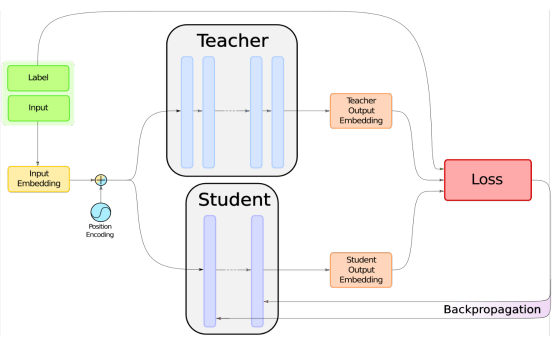

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install transformers==4.28.0 -q

print("Completed!")

Completed!


In [ ]:
import transformers
from transformers import AutoTokenizer
print(transformers.__version__) #Must be 4.28 (we encountered some bugs with other versions)

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

print("\nCompleted!")

4.28.0

Completed!


In [ ]:
#some costants and hyperparameters
batch_size = 12
max_length = 384
doc_stride = 128 
pad_on_right = tokenizer.padding_side == "right"

print("Completed!")

Completed!


####<h4><b>🛠️Dataset preparation</b></h4>
<p>Before moving on to the interesting part i.e. model training, there's need to prepare our dataset in such a way that the model likes it.</p>

In [ ]:
def prepare_train_features(df):
    examples = {}
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in df["question"].tolist()]
    examples["context"] = [c for c in df["context"].tolist()]
    examples["answers"] = df[['answer','answer_start']].to_dict('records')
    
    for d in examples["answers"]:
      for k, v in d.items():
          d[k] = [v]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["answer"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples
  
print("Completed!")

Completed!


In [ ]:
!pip install datasets -q

print("Completed!")

Completed!


In [ ]:
#Let's adapt our pandas dataframe to a more suitable structure fr our model
from datasets import Dataset
tokenized_train = prepare_train_features(train_df)
tokenized_val = prepare_train_features(dev_df)

tokenized_train_dict = {
    "input_ids": tokenized_train["input_ids"],
    "attention_mask": tokenized_train["attention_mask"],
    "start_positions": tokenized_train["start_positions"],
    "end_positions": tokenized_train["end_positions"],
}
dataset_train = Dataset.from_dict(tokenized_train_dict)

tokenized_val_dict = {
    "input_ids": tokenized_val["input_ids"],
    "attention_mask": tokenized_val["attention_mask"],
    "start_positions": tokenized_val["start_positions"],
    "end_positions": tokenized_val["end_positions"],
}
dataset_val = Dataset.from_dict(tokenized_val_dict)

print("Completed!")

Completed!


In [ ]:
!pip install accelerate -U -q

print("Completed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 16.7 MB/s eta 0:00:00
Completed!


Let's load the starting point model `DistilBERT` base uncased (pretrained). Also defined the trainer object.

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer, default_data_collator

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
data_collator = default_data_collator

print("Completed!")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Completed!


In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_dir = f"{model_name}-finetuned-squad/logs",
)

print("Completed!")

Completed!


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Completed!")

Completed!


####<h3><b>🏋️‍♂️Let's train our model</b></h3>
<p>Please note that this will take a long time, so if you have trained the model once you can skip this cell and load directly your FineTuned model from the next cell.</p>

In [ ]:
train_result = trainer.train()
model.save_pretrained("./Models/bertv4", from_pt=True) # Saves the model after the train phase

# Compute train results
metrics = train_result.metrics

# Save train results
trainer.log_metrics("all", metrics)
trainer.save_metrics("all", metrics)

with open(f"{model_name}-finetuned-squad/trainer_state.json", "w") as output_file:
    json.dump(trainer.state.log_history, output_file)

print("Completed!")

In [ ]:
model = model.from_pretrained('./Models/bertv4') # Load the trained model
print("Completed!")

Completed!


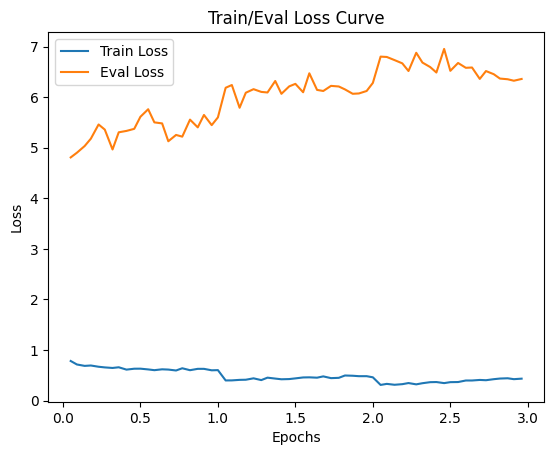


Completed!


In [ ]:
import json

train_losses_x, train_losses_y = [], []
val_losses_x, val_losses_y = [], []

trainer_state = json.load(open(f"{model_name}-finetuned-squad/trainer_state.json", 'r'))

for state in trainer_state:
  if('loss' in state):
    train_losses_x.append(state['epoch'])
    train_losses_y.append(state['loss'])
  if('eval_loss' in state):
    val_losses_x.append(state['epoch'])
    val_losses_y.append(state['eval_loss'])

plt.plot(train_losses_x, train_losses_y, label='Train Loss')
plt.plot(val_losses_x, val_losses_y, label='Eval Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train/Eval Loss Curve')

plt.legend()
plt.show()

print("\nCompleted!")

####<h3><b>🎓Let's evaluate our model</b></h3>
<p>Finally! Now is the time to assess the effectiveness of the model training process and evaluate its performance.<br><br>
<i>Note that as for t5 this code is drawn from the official SQuAD2.0 evaluation script (slightly modified)</i>
</p>


In [ ]:
tmp_dev_df_answ =  dev_df[dev_df['is_impossible'] == False][['question', 'context', 'answer', 'is_impossible']]

grouped_df_answ = tmp_dev_df_answ.groupby('context').agg({'answer': list, 'question': list, 'is_impossible': list}).reset_index()
grouped_df_answ.head()

,context,answer,question,is_impossible
0,"""Southern California"" is not a formal geograph...","[37° 9' 58.23"", 11, ten, Tehachapi Mountains, ...","[Geographically speaking, where is California'...","[False, False, False, False, False, False]"
1,"""The Islamic State"", formerly known as the ""Is...","[Wahhabi/Salafi jihadist extremist militant, W...","[What type of group is The Islamic State?, Wha...","[False, False, False, False, False, False, Fal..."
2,"""The word ‘empire’ comes from the Latin word i...","[distinction, the world systems theory, world ...",[The amount of land a country controls is its ...,"[False, False, False, False, False, False, Fal..."
3,2013 Economics Nobel prize winner Robert J. Sh...,"[2013, rising inequality, negative, negative e...",[What year did Robert J. Shiller win an Econom...,"[False, False, False, False, False, False]"
4,A B cell identifies pathogens when antibodies ...,"[B cell, B, A B cell, proteolysis, lymphokines]",[What kind of cell identifies pathogens when t...,"[False, False, False, False, False]"


In [ ]:
tot_f1_scores = defaultdict(list)
tot_em_scores = defaultdict(list)

for context in grouped_df_answ['context']:
  q = grouped_df_answ[grouped_df_answ['context'] == context]['question'].tolist()[0]
  a = grouped_df_answ[grouped_df_answ['context'] == context]['answer'].tolist()[0]
  q_type = grouped_df_answ[grouped_df_answ['context'] == context]['is_impossible'].tolist()[0]

  if len(context) <= 512:
    for q, a in zip(q, a):
      give_an_answer_bert(context, q, a, q_type)

print("\nCompleted!")

Question: A function problem is an example of what?
Prediction: computational problem
True Answer: a computational problem
EM: 1
F1: 1.0


Question: How many outputs are expected for each input in a function problem?
Prediction: single
True Answer: a single output
EM: 0
F1: 0.6666666666666666


Question: How many outputs are expected for each input in a function problem?
Prediction: single
True Answer: single
EM: 1
F1: 1.0


Question: The traveling salesman problem is an example of what type of problem?
Prediction: computational
True Answer: A function problem
EM: 0
F1: 0


Question: The traveling salesman problem is an example of what type of problem?
Prediction: computational
True Answer: function
EM: 0
F1: 0


Question: The traveling salesman problem is an example of what type of problem?
Prediction: computational
True Answer: function problem
EM: 0
F1: 0


Question: In addition to the traveling salesman problem, what is another example of a function problem?
Prediction: integer fac

Let's print out the `F1 score` and the `EM` on average only for answerable questions.

In [ ]:
max_f1 = {q: max(f1) for q, f1 in tot_f1_scores.items()}
max_em = {q: max(em) for q, em in tot_em_scores.items()}

print("F1 mean: " + str(sum(max_f1.values()) / len(max_f1.values())))

print("EM mean: " + str(sum(max_em.values()) / len(max_em.values())))

print("\nCompleted!")

F1 mean: 0.7725482360565284
EM mean: 0.6657754010695187

Completed!


In [ ]:
tot_f1_scores = defaultdict(list)
tot_em_scores = defaultdict(list)

tmp_dev_df_mixed =  dev_df[['question', 'context', 'answer', 'is_impossible']]

grouped_df_mixed = tmp_dev_df_mixed.groupby('context').agg({'answer': list, 'question': list, 'is_impossible': list}).reset_index()
grouped_df_mixed.head()

,context,answer,question,is_impossible
0,"""Southern California"" is not a formal geograph...","[37° 9' 58.23"", 11, ten, Tehachapi Mountains, ...","[Geographically speaking, where is California'...","[False, False, False, False, False, False, Tru..."
1,"""The Islamic State"", formerly known as the ""Is...","[Wahhabi/Salafi jihadist extremist militant, W...","[What type of group is The Islamic State?, Wha...","[False, False, False, False, False, False, Fal..."
2,"""The word ‘empire’ comes from the Latin word i...","[distinction, the world systems theory, world ...",[The amount of land a country controls is its ...,"[False, False, False, False, False, False, Fal..."
3,2013 Economics Nobel prize winner Robert J. Sh...,"[2013, rising inequality, negative, negative e...",[What year did Robert J. Shiller win an Econom...,"[False, False, False, False, False, False, Tru..."
4,A B cell identifies pathogens when antibodies ...,"[B cell, B, A B cell, proteolysis, lymphokines...",[What kind of cell identifies pathogens when t...,"[False, False, False, False, False, True, True..."


In [ ]:
for context in grouped_df['context']:
  q = grouped_df[grouped_df['context'] == context]['question'].tolist()[0]
  a = grouped_df[grouped_df['context'] == context]['answer'].tolist()[0]
  q_type = grouped_df[grouped_df['context'] == context]['is_impossible'].tolist()[0]

  if len(context) <= 512:
    for q, a in zip(q, a):
      give_an_answer_bert(context,q,a, q_type)

print("\nCompleted!")

Output streaming troncato alle ultime 5000 righe.
Question: Who is the UK's smallest digital subscription television company?
Prediction: bskyb
True Answer: BSkyB
EM: 1
F1: 1.0


Question: What year did BSkyB remove Sky Italia?
Prediction: 2014
True Answer: 2014
EM: 1
F1: 1.0


Question: When did BSkyB become the largest US television company?
Prediction: 
True Answer: 1990
EM: 0
F1: 0


Question: What company no longer trades as Sky?
Prediction: sky uk limited
True Answer: Sky UK Limited
EM: 1
F1: 1.0


Question: Which team was suspended from the MLS?
Prediction: chivas
True Answer: Chivas USA
EM: 0
F1: 0.6666666666666666


Question: Which team was suspended from the MLS?
Prediction: chivas
True Answer: Chivas
EM: 1
F1: 1.0


Question: How many teams did Los Angeles used to have?
Prediction: two
True Answer: two
EM: 1
F1: 1.0


Question: Which year resulted in the suspension of one of the two soccer teams?
Prediction: 2014
True Answer: 2014
EM: 1
F1: 1.0


Question: What was the name 

Let's print out the `F1 score` and the `EM` on average both for answerable and not answerable questions.

In [ ]:
max_f1 = {q: max(f1) for q, f1 in tot_f1_scores.items()}
max_em = {q: max(em) for q, em in tot_em_scores.items()}

print("F1 mean: " + str(sum(max_f1.values()) / len(max_f1.values())))

print("EM mean: " + str(sum(max_em.values()) / len(max_em.values())))

print("\nCompleted!")

F1 mean: 0.6531435854570667
EM mean: 0.5481283422459893

Completed!


Let'see some pratical examples!

In [ ]:
context = """Natural language processing (NLP) is an interdisciplinary subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. The goal is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.
              Challenges in natural language processing frequently involve speech recognition, natural-language understanding, and natural-language generation.
              Natural language processing has its roots in the 1950s. Already in 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence, though at the time that was not articulated as a problem separate from artificial intelligence. The proposed test includes a task that involves the automated interpretation and generation of natural language.  """

query = "What is Natural Language Processing?"

prediction = predict(context,query)

print("1) " + prediction + "\n")

context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is a pandemic of coronavirus disease 2019 (COVID-19) 
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China. 
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic 
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are 
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. 
              It may also spread via contaminated surfaces."""

query = "What is caused by COVID-19?"

prediction = predict(context,query)

print("2) " + prediction)

print("\nCompleted!")

1) an interdisciplinary subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language

2) severe acute respiratory syndrome coronavirus 2


## 👽 Possible extensions


### 🎲 SQuAD2.0 questions asked to text-davinci-003 

What would happen if we present the questions to one of the state-of-the-art (SOTA) models without any fine-tuning specifically for this task?

Test Performed: 


*   Ask a question
*   Ask a question given a context
*   Ask a question given a context with prompt engineering
*   Ask a not-anserable question given a context





In [ ]:
!pip install openai -q 

print("\nCompleted!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.0 MB/s eta 0:00:00

Completed!


In [ ]:
import openai

openai.api_key = 'your-key'

# TASK 1 - ASK THE QUESTION
questions = dev_df['question'].unique()[:5]

# Set up the prompt
for question in questions:
  prompt = question

  # Generate a response
  response = openai.Completion.create(
      engine="text-davinci-003", 
      prompt=prompt, 
      max_tokens=64, 
      n=1, 
      stop=None, 
      temperature=0.5
  )

  print(bcolors.BOLD + 'Prompt: ' + bcolors.ENDC + '{}\n'.format(prompt))
  print(bcolors.BOLD + 'Correct answer(s): ' + bcolors.ENDC + '{}\n'.format(dev_df[dev_df['question']==question]['answer'].tolist()))
  print(bcolors.BOLD + 'Model response: ' + bcolors.ENDC + ' {}\n\n---\n'.format(response.choices[0].text))

  print("\nCompleted!")

Prompt: In what country is Normandy located?

Correct answer(s): ['France']

Model response:  

Normandy is located in France.

---

Prompt: When were the Normans in Normandy?

Correct answer(s): ['10th and 11th centuries', 'in the 10th and 11th centuries']

Model response:  

The Normans first settled in Normandy in the late 9th century.

---

Prompt: From which countries did the Norse originate?

Correct answer(s): ['Denmark, Iceland and Norway']

Model response:  

The Norse originated from Scandinavia, which includes the modern-day countries of Denmark, Norway, and Sweden.

---

Prompt: Who was the Norse leader?

Correct answer(s): ['Rollo']

Model response:  

The most famous Norse leader was Ragnar Lodbrok, a legendary Viking king who lived in the 9th century. He is known for leading successful raids against France and England and is often portrayed in popular culture.

---

Prompt: What century did the Normans first gain their separate identity?

Correct answer(s): ['10th centur

In [ ]:
# TASK 2 - ASK THE QUESTION GIVEN THE CONTEXT

questions = dev_df['question'].unique()[:5]
context = dev_df[dev_df['question']==questions[0]]['context'].values[0]

# Set up the prompt
for question in questions:
  
  prompt = context + '\n\n' + question

  # Generate a response
  response = openai.Completion.create(
      engine="text-davinci-003", 
      prompt=prompt, 
      max_tokens=64, 
      n=1, 
      stop=None, 
      temperature=0.5
  )

  print(bcolors.BOLD + 'Prompt: ' + bcolors.ENDC + '{}\n'.format(prompt))
  print(bcolors.BOLD + 'Correct answer(s): ' + bcolors.ENDC + '{}\n'.format(dev_df[dev_df['question']==question]['answer'].tolist()))
  print(bcolors.BOLD + 'Model response: ' + bcolors.ENDC + ' {}\n\n---\n'.format(response.choices[0].text))

  print("\nCompleted!")

Prompt: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.

In what country is Normandy located?

Correct answer(s): ['France']

Model response:  
France

---

Prompt: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Nor

In [ ]:
# TASK 3 - PROMPT ENGINEERING

questions = dev_df['question'].unique()[:5]
context = dev_df[dev_df['question']==questions[0]]['context'].values[0]
instruction = 'Given a context and a question return only the words of the context answering the question. The answer must be short.'

# Set up the prompt
for question in questions:
  
  prompt = instruction + '\n\n' + context + '\n\n' + question

  # Generate a response
  response = openai.Completion.create(
      engine="text-davinci-003", 
      prompt=prompt, 
      max_tokens=64, 
      n=1, 
      stop=None, 
      temperature=0.5
  )

  print(bcolors.BOLD + 'Prompt: ' + bcolors.ENDC + '{}\n'.format(prompt))
  print(bcolors.BOLD + 'Correct answer(s): ' + bcolors.ENDC + '{}\n'.format(dev_df[dev_df['question']==question]['answer'].tolist()))
  print(bcolors.BOLD + 'Model responce: ' + bcolors.ENDC + ' {}\n\n---\n'.format(response.choices[0].text))

  print("\nCompleted!")

Prompt: Given a context and a question return only the words of the context answering the question. The answer must be short.

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.

In what country is Normandy located?

Correct answer(s): ['France']

Model responce:  
France

---

Prompt: Given a context and a

In [ ]:
# TASK 4 - ASK AN UNANSWEABLE QUESTION 

question = 'When did the Frankish identity emerge?'
context = dev_df[dev_df['question']==questions[0]]['context'].values[0]
instruction = 'Given a context and a question return only the words of the context answering the question. The answer must be short. Write "The information available is not sufficient to answer the question" if the context does not contain the information.'

def generate(prompt):
  # Generate a response
  response = openai.Completion.create(
        engine="text-davinci-003", 
        prompt=prompt, 
        max_tokens=64, 
        n=1, 
        stop=None, 
        temperature=0.5
  )

  print(bcolors.BOLD + 'Prompt: ' + bcolors.ENDC + '{}\n'.format(prompt))
  print(bcolors.BOLD + 'Model response: ' + bcolors.ENDC + ' {}\n\n---\n'.format(response.choices[0].text))

generate(question)
generate(context + '\n\n' + question)
generate(instruction + '\n\n' + context + '\n\n' + question)

print("\nCompleted!")

Prompt: When did the Frankish identity emerge?

Model response:  

The Frankish identity emerged in the late 5th century, when the Franks established a kingdom in what is now modern-day France. Under the rule of the Merovingian dynasty, the Franks developed their own culture and identity, which was distinct from the surrounding Germanic and Roman cultures.

---

Prompt: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans

### 3️⃣ GPT-3 ada for SQuAD2.0 questions classification

We attempted to fine-tune a model from the OpenAI for a binary classification task. The classification labels were set to 0 if the is_impossible value was False, and 1 otherwise.

We utilize GPT-3 `ada`, usually the fastest model in the GPT-3 series, and the one with the lowest cost.

Nevertheless, for budget constraints (5$ free x account) we reduced the training and the validation sets as follow:


*   Training set: 6000 answerable question + 6000 not-answerable question
*   Dev set: 500 answerable question + 500 not-answerable question

Therefore, these results should be considered as an experiment and cannot be considered reliable.

Comparing this last run with the previous, we notice an increase of 3% in the accuracy increasing the training size from 10000 to 12000 samples. 

<img src=http://jalammar.github.io/images/gpt3/08-gpt3-tokens-transformer-blocks.gif width="700">

In [ ]:
import openai

print("\nCompleted!")


Completed!


####<h4><b>🛠️Dataset and Model preparation</b></h4>

In [ ]:
x = train_df[train_df['is_impossible'] == False].sample(frac=1)[:6000]
y = train_df[train_df['is_impossible'] == True].sample(frac=1)[:6000]
train_df = pd.concat([x,y], ignore_index=True)

print("Completed!")

Completed!


In [ ]:
x = dev_df[dev_df['is_impossible'] == False].sample(frac=1)[:500]
y = dev_df[dev_df['is_impossible'] == True].sample(frac=1)[:500]
dev_df = pd.concat([x,y], ignore_index=True)

print("Completed!")

Completed!


Let's prepare prompts and competitions:

Instead of explicitly providing the model with the text, context, and a list of possible categories for classification, we encode the text and context in a structured format and use the '###' token to indicate that the model should generate the classification answer.



In [ ]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
  
  # Create prompt
  df["prompt"] = "Question:\n" + df["question"] \
    + "\n\nContext:\n" + df["context"] \
    + "\n\n###\n\n"

  # Add completion
  df["completion"] = df["is_impossible"].astype(int).astype(str)

  
  return df[["prompt", "completion"]]

train_df_prepared = prepare_data(train_df)
dev_df_prepared = prepare_data(dev_df)

# Print an example
random_i = np.random.choice(train_df_prepared.index, size=1)[0]
print(train_df_prepared["prompt"][random_i])
print(train_df_prepared["completion"][random_i])

print("\nCompleted!")

Question:
How much revenue were teams given during 2013/14?

Context:
The competition formed as the FA Premier League on 20 February 1992 following the decision of clubs in the Football League First Division to break away from the Football League, which was originally founded in 1888, and take advantage of a lucrative television rights deal. The deal was worth £1 billion a year domestically as of 2013–14, with BSkyB and BT Group securing the domestic rights to broadcast 116 and 38 games respectively. The league generates €2.2 billion per year in domestic and international television rights. In 2014/15, teams were apportioned revenues of £1.6 billion.

###


1

Completed!


Save the dataset to JSONL file

In [ ]:
if os.path.exists("train.jsonl"): os.remove("train.jsonl")
if os.path.exists("val.jsonl"): os.remove("val.jsonl")
if os.path.exists("train_prepared.jsonl"): os.remove("train_prepared.jsonl")
if os.path.exists("val_prepared.jsonl"): os.remove("val_prepared.jsonl")

train_df_prepared.to_json("train.jsonl", orient='records', lines=True)
dev_df_prepared.to_json("val.jsonl", orient='records', lines=True)

print("Completed!")

Completed!


Use the `fine_tunes.prepare_data` tool to remove long samples. WARNING: do not split train and validation, it has already been done.


In [ ]:
!openai tools fine_tunes.prepare_data -f train.jsonl -q
!openai tools fine_tunes.prepare_data -f val.jsonl -q

print("\nCompleted!")

Upload files to openai and create a fine-tuning job

In [ ]:
openai.api_key = 'your-key'

with open("train_prepared.jsonl") as f:
  response = openai.File.create(file=f, purpose='fine-tune')
  training_file_id = response["id"]

with open("val_prepared.jsonl") as f:
  response = openai.File.create(file=f, purpose='fine-tune')
  validation_file_id = response["id"]

response = openai.FineTune.create(model="ada", training_file=training_file_id, validation_file=validation_file_id, compute_classification_metrics=True, classification_positive_class=" 1")
job_id = response["id"]
print(job_id)
print(response)

print("\nCompleted!")

####<h3><b>🏋️‍♂️Let's train our model</b></h3>

In [ ]:
from datetime import datetime
import time

REFRESH_SECONDS = 10

status = None
events_printed = 0

while status is None or status == 'pending' or status == 'running':
  response = openai.FineTune.retrieve(id=job_id)
  status = response["status"]

  for i in range(events_printed, len(response["events"])):
    e = response["events"][i]
    created_at = datetime.fromtimestamp(e["created_at"])
    print(created_at.strftime("[%Y-%m-%d, %H:%M:%S]"), e["message"])
    
  events_printed = len(response["events"])
  time.sleep(REFRESH_SECONDS)

  print("\nCompleted!")

[2023-05-27, 07:14:42] Created fine-tune: ft-uBgN3ooAYkGlr8r3WsuxIflX
[2023-05-27, 07:16:13] Fine-tune costs $3.50
[2023-05-27, 07:16:13] Fine-tune enqueued. Queue number: 0
[2023-05-27, 07:16:14] Fine-tune started
[2023-05-27, 07:22:29] Completed epoch 1/4
[2023-05-27, 07:35:04] Completed epoch 3/4
[2023-05-27, 07:42:04] Uploaded model: ada:ft-personal-2023-05-27-07-42-04
[2023-05-27, 07:42:05] Uploaded result file: file-JRvkcoxA3SS2V083erGy4Cej
[2023-05-27, 07:42:05] Fine-tune succeeded


In [ ]:
response = openai.FineTune.retrieve(id=job_id)
model_id = response["fine_tuned_model"]
results_file_id = response["result_files"][0]["id"]

print("\nCompleted!")

Save the results

In [ ]:
import requests
from io import BytesIO
openai_api_key = 'your-key'

response = requests.get(f'https://api.openai.com/v1/files/{results_file_id}/content', headers={'Authorization': f'Bearer {openai_api_key}'})
results = pd.read_csv(BytesIO(response.content))
results[results['classification/accuracy'].notnull()].tail(1)

print("\nCompleted!")

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3001,3002,16198176,48032,0.013677,1.0,1.0,NaN,NaN,NaN,0.669355,0.667969,0.684,0.744764,0.77162,0.675889


Plot Train and Validation loss

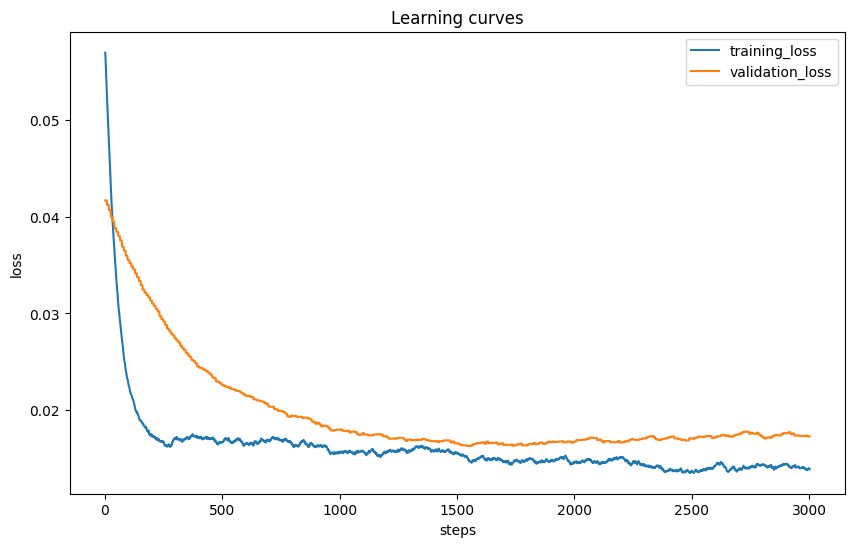

In [ ]:
results_for_graph = results[['step', 'training_loss', 'validation_loss']].copy()
results_for_graph['training_loss'] = results_for_graph['training_loss'].ewm(span=100, adjust=False).mean()
results_for_graph['validation_loss'] = results_for_graph['validation_loss'].ewm(span=100, adjust=False).mean()

fig, ax = plt.subplots(figsize=(10,6))
plt.title('Learning curves')
plt.xlabel('steps')
plt.ylabel('loss')
plt.plot(results_for_graph['step'], results_for_graph['training_loss'], label='training_loss')
plt.plot(results_for_graph['step'], results_for_graph['validation_loss'], label='validation_loss')
leg = plt.legend(loc='upper right')
plt.show()

print("\nCompleted!")

####<h3><b>🎓Let's evaluate our model</b></h3>

In [ ]:
results

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
0,1,4624,16,0.056918,0.000,0.000,0.041674,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,2,8992,32,0.052287,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,17584,48,0.022074,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,21568,64,0.033987,0.375,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,26576,80,0.020924,0.625,0.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2997,2998,16177248,47968,0.011625,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2998,2999,16181744,47984,0.016039,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999,3000,16187520,48000,0.013572,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000,3001,16193296,48016,0.011593,1.000,1.000,0.017348,0.6875,0.6875,NaN,NaN,NaN,NaN,NaN,NaN


Plot the classification metrics



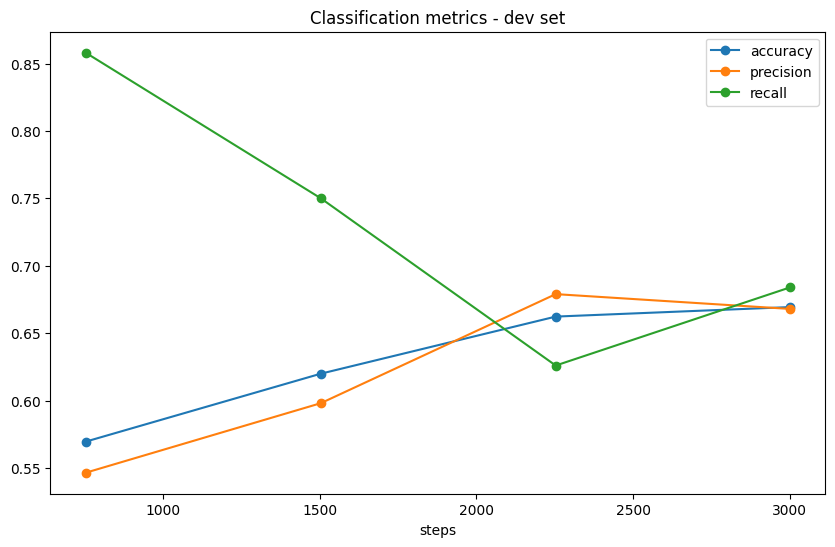

In [ ]:
results_for_graph = results.copy()

fig, ax = plt.subplots(figsize=(10,6))
plt.title('Classification metrics - dev set')
plt.xlabel('steps')
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/accuracy'])],
    results_for_graph['classification/accuracy'][np.isfinite(results_for_graph['classification/accuracy'])],
    label='accuracy',
    linestyle='-',
    marker='o'
)
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/precision'])],
    results_for_graph['classification/precision'][np.isfinite(results_for_graph['classification/precision'])],
    label='precision',
    linestyle='-',
    marker='o'
)
plt.plot(
    results_for_graph['step'][np.isfinite(results_for_graph['classification/recall'])],
    results_for_graph['classification/recall'][np.isfinite(results_for_graph['classification/recall'])],
    label='recall',
    linestyle='-',
    marker='o'
)
leg = plt.legend(loc='upper right')
plt.show()

print("\nCompleted!")

### 📑 Expanding beyond the SQuAD2.0 dataset

Numerous datasets have been developed for question answering, including boolean question answering, with the SQuAD dataset serving as a reference. Here are a few examples of such datasets:



*   [MultiRC](https://aclanthology.org/N18-1023/) - questions and answers based on sets of related documents
*   [ReCoRD](https://arxiv.org/abs/1810.12885) - questions and answers that require understanding and inference based on a given passage, including selecting multiple possible correct answers
*   [BoolQ](https://arxiv.org/abs/1905.10044) - contains questions transformed into a boolean format, where the answer can be either "yes" or "no"

However, due to time constraints, we will not continue with the in-depth analysis of these documents.



# 📖Conclusions
The task required by this dataset is a complicated one that challenges even the best performing models. From our point of view we archived good performances (especially with DistillBERT and T5) considering the fact that, due to computational and time limits we coudn't be able to perform some tasks such as hyperparameter tuning with search algorithms like GridSearch, RandomSearch etc... Also the impossible questions are partially considered in the prediction, a more efficient way of ditinguish between possible and impossible answer should be considered (like considering a confidence treshold).

### References
* <i>Know What You Don't Know: Unanswerable Questions for SQuAD - P. Rajpurkar et. al, 2018</i> [[arxiv.org](https://arxiv.org/abs/1806.03822)]
* <i>Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer - C. Raffel et. al, 2019</i> [[arxiv.org](https://arxiv.org/abs/1910.10683)]

* <i>HuggingFace docs</i> [[huggingface.co](https://huggingface.co/docs)]

* <i>NLP course (slides/notebooks)</i> [[polimi.it](https://www4.ceda.polimi.it/manifesti/manifesti/controller/ManifestoPublic.do?EVN_DETTAGLIO_RIGA_MANIFESTO=evento&aa=2022&k_cf=225&k_corso_la=481&k_indir=T2A&codDescr=088946&lang=IT&semestre=2&idGruppo=4475&idRiga=281848)]
